In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from IPython import display
import io
import PIL
from matplotlib import pyplot as plt
import math

In [3]:
from sklearn.metrics import accuracy_score
from torch.nn import Softmax
from torch.nn import functional

In [4]:
import time

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Parameter

import numpy as np

In [7]:
torch.manual_seed(2)

In [8]:
from Stupid_digits import stupid_digits_dataset
from Stupid_digits import get_digit

In [9]:
X,y = stupid_digits_dataset()

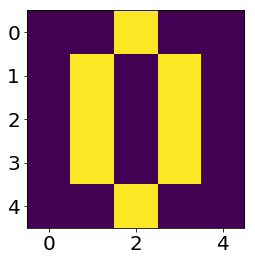

In [10]:
plt.imshow(get_digit(0).reshape(5,5))
plt.show()

In [11]:
def get_layer_info(layer):
    layer_str = str(layer)
    type_name = layer_str[:layer_str.find('(')].strip()
    return type_name


In [12]:
X = torch.from_numpy(X).float().cuda()
type(X)

torch.cuda.FloatTensor

In [ ]:
class IF(nn.Module):
    # dv(t)/dt = I(t)/tau_v
    # dI(t)/dt = -I(t)/tau_I

    # dv(t)/dt = -dI(t)/dt *(tau_I/tau_v)
    def __init__(self, neurons=1, tau_v = 20, tau_I = 15, tau_mean = 100, I_teacher_amplitude=0, tau_threshold=50, name='LIF', init_type='eye'):
        super(LIF, self).__init__()
        
        # layer parameters
        self.neurons = neurons
        self.name = name
        
        #print(('Creating LIF neuron group {}, init {}').format(self.neurons, self.init_type))
        # init neuron model parameters
        self.tau_v = tau_v
        self.tau_I = tau_I
        self.tau_threshold = tau_threshold
        self.tau_mean = tau_mean
        self.v = torch.cuda.FloatTensor(self.neurons).fill_(0)
        self.I = torch.cuda.FloatTensor(self.neurons).fill_(0)
        self.I_inp = torch.cuda.FloatTensor(self.neurons).fill_(0)
        self.I_neg = torch.cuda.FloatTensor(self.neurons).fill_(0)
        self.I_teacher = torch.cuda.FloatTensor(self.neurons).fill_(0)
        self.I_teacher_amplitude = I_teacher_amplitude
        self.instant_rate = torch.cuda.FloatTensor(self.neurons).uniform_()
        self.mean_rate = torch.cuda.FloatTensor(self.neurons).uniform_()
        self.threshold = normalize(torch.cuda.FloatTensor(self.neurons).fill_(1))
        self.c_inp = 1
        self.c_neg = 1
        
        self.refractoriness_state = torch.cuda.FloatTensor(neurons).fill_(0)
        
        # monitors init
        self.monitor = Monitor(['v','I_inp','I_neg','I','threshold','instant_rate','mean_rate'])
        self.monitor([self.v, self.I_inp, self.I_neg, self.I, self.threshold, self.instant_rate, self.mean_rate])
            
    def update_state(self, weighted_input):
        self.I_inp -= self.I_inp/self.tau_I
        self.I_neg -= self.I_neg/self.tau_I
        self.I_inp += weighted_input

        self.I_inp = normalize(self.I_inp)
        self.I_neg = normalize(self.I_neg)
            
        self.I = self.I_inp * self.c_inp + self.I_teacher + self.I_neg * self.c_neg
        self.I = normalize(self.I)
        self.v += torch.addcmul(torch.cuda.FloatTensor(self.v.size()).fill_(0), 
                                (self.I)/self.tau_v, 
                                (1-self.refractoriness_state))
        self.v = torch.clamp(self.v,0,100)
        
    #def refractoriness_check(self):
    #    return self.refractoriness_state
    
    def get_spikes(self):
        # get binary spike events
        self.spikes = (self.v >= self.threshold).float()
        
        # set v to zero to those neurons that spiked
        self.v = torch.addcmul(torch.cuda.FloatTensor(self.v.size()).fill_(0), 
                               self.v,
                               (1-self.spikes))
        
        # increase threshold  to those neurons that spiked, decay for others
        self.threshold += -self.threshold/self.tau_threshold + 0.002 * self.spikes * self.neurons
        self.threshold = torch.clamp(normalize(self.threshold), 0.2, 1)
        
        
        # set those neurons that spiked into the refractoriness state
        self.refractoriness_state = self.spikes
        
        # update those neurons that spiked instant and mean firing rate
        self.instant_rate += (self.spikes.float() - self.instant_rate)/self.tau_I
        self.mean_rate += (self.spikes.float() - self.mean_rate)/self.tau_mean
        
        return self.spikes
        
    def forward(self, weighted_input, target=None):
        # set teacher current
        self.I_teacher = torch.cuda.FloatTensor(self.I_teacher.size()).fill_(0)
        if target is not None:
            self.I_teacher[target] = self.I_teacher_amplitude
            
        #update v and I in neuron 
        self.update_state(weighted_input)
        
        #get spikes for this t
        x = self.get_spikes()
        
        #write to monitor
        self.monitor([self.v, self.I_inp, self.I_neg, self.I, self.threshold, self.instant_rate, self.mean_rate])
        return x
    
    def reset_parameters(self):
        self.v.fill_(0)
        self.I.fill_(0)
        self.I_inp.fill_(0)
        self.I_neg.fill_(0)

In [27]:
class LIF(nn.Module):
    # dv/dt = (I-v)/tau_v
    # dI/dt = -I/tau_I
    def __init__(self, neurons=1, tau_v = 20, tau_I = 15, tau_mean = 100, I_teacher_amplitude=0, tau_threshold=50, name='LIF', init_type='eye'):
        super(LIF, self).__init__()
        
        # layer parameters
        self.neurons = neurons
        self.name = name
        
        #print(('Creating LIF neuron group {}, init {}').format(self.neurons, self.init_type))
        # init neuron model parameters
        self.tau_v = tau_v
        self.tau_I = tau_I
        self.tau_threshold = tau_threshold
        self.tau_mean = tau_mean
        self.v = torch.cuda.FloatTensor(self.neurons).fill_(0)
        self.I = torch.cuda.FloatTensor(self.neurons).fill_(0)
        self.I_inp = torch.cuda.FloatTensor(self.neurons).fill_(0)
        self.I_neg = torch.cuda.FloatTensor(self.neurons).fill_(0)
        self.I_teacher = torch.cuda.FloatTensor(self.neurons).fill_(0)
        self.I_teacher_amplitude = I_teacher_amplitude
        self.instant_rate = torch.cuda.FloatTensor(self.neurons).uniform_()
        self.mean_rate = torch.cuda.FloatTensor(self.neurons).uniform_()
        self.threshold = normalize(torch.cuda.FloatTensor(self.neurons).fill_(1))
        self.c_inp = 1
        self.c_neg = 1
        
        self.refractoriness_state = torch.cuda.FloatTensor(neurons).fill_(0)
        
        # monitors init
        self.monitor = Monitor(['v','I_inp','I_neg','I','threshold','instant_rate','mean_rate'])
        self.monitor([self.v, self.I_inp, self.I_neg, self.I, self.threshold, self.instant_rate, self.mean_rate])
            
    def update_state(self, weighted_input):
        self.I_inp -= self.I_inp/self.tau_I
        self.I_neg -= self.I_neg/self.tau_I
        self.I_inp += weighted_input
        

        self.I_inp = normalize(self.I_inp)
        self.I_neg = normalize(self.I_neg)
            
        self.I = self.I_inp * self.c_inp + self.I_teacher + self.I_neg * self.c_neg
        self.I = normalize(self.I)
        self.v += torch.addcmul(torch.cuda.FloatTensor(self.v.size()).fill_(0), 
                                (self.I-self.v)/self.tau_v, 
                                (1-self.refractoriness_state))
        self.v = torch.clamp(self.v,0,100)
        
    #def refractoriness_check(self):
    #    return self.refractoriness_state
    
    def get_spikes(self):
        # get binary spike events
        self.spikes = (self.v >= self.threshold).float()
        
        # set v to zero to those neurons that spiked
        self.v = torch.addcmul(torch.cuda.FloatTensor(self.v.size()).fill_(0), 
                               self.v,
                               (1-self.spikes))
        
        # increase threshold  to those neurons that spiked, decay for others
        self.threshold += -self.threshold/self.tau_threshold + 0.002 * self.spikes * self.neurons
        self.threshold = torch.clamp(normalize(self.threshold), 0.2, 1)
        
        
        # set those neurons that spiked into the refractoriness state
        self.refractoriness_state = self.spikes
        
        # update those neurons that spiked instant and mean firing rate
        self.instant_rate += (self.spikes.float() - self.instant_rate)/self.tau_I
        self.mean_rate += (self.spikes.float() - self.mean_rate)/self.tau_mean
        
        return self.spikes
        
    def forward(self, weighted_input, target=None):
        # set teacher current
        self.I_teacher = torch.cuda.FloatTensor(self.I_teacher.size()).fill_(0)
        if target is not None:
            self.I_teacher[target] = self.I_teacher_amplitude
            
        #update v and I in neuron 
        self.update_state(weighted_input)
        
        #get spikes for this t
        x = self.get_spikes()
        
        #write to monitor
        self.monitor([self.v, self.I_inp, self.I_neg, self.I, self.threshold, self.instant_rate, self.mean_rate])
        return x
    
    def reset_parameters(self):
        self.v.fill_(0)
        self.I.fill_(0)
        self.I_inp.fill_(0)
        self.I_neg.fill_(0)
    
class Monitor(nn.Module):
    def __init__(self, var_list, record_time=300):
        super(Monitor, self).__init__()
        self.record_time = record_time
        self.monitor_dict = {}
        self.var_list = var_list
        #print("Creating Monitor")
        for var in var_list:
            self.monitor_dict[var] = []
            
        self.softmax = Softmax()
    
    def predict(self):
        return np.argmax(np.mean(output_layer.monitor.monitor_dict['instant_rate'][-10:],axis=0))
    
    def predict_proba(self):
        return self.softmax(np.mean(output_layer.monitor.monitor_dict['instant_rate'][-10:],axis=0))
    
    def forward(self, x):
        for i,value in enumerate(x):
            self.monitor_dict[self.var_list[i]].append(value.clone().cpu().numpy().tolist())
            if len(self.monitor_dict[self.var_list[i]]) > self.record_time:
                self.monitor_dict[self.var_list[i]] = self.monitor_dict[self.var_list[i]][1:]
    
        
            

In [38]:
class Connection(nn.Module):
    def __init__(self, pre_layer=None, post_layer=None, lr=0.1, decay_time=10000, init_type='eye', learning_rule='BCM', c_diff=1):
        super(Connection, self).__init__()
        
        self.pre_layer = pre_layer
        self.post_layer = post_layer
        self.lr = lr
        self.c_diff = c_diff
        
        self.decay_time = decay_time
        self.weight = torch.cuda.FloatTensor(self.pre_layer.neurons, self.post_layer.neurons).fill_(0)
        self.init_type = init_type
        self.learning_rule = learning_rule
        self.init_weights()
        
        pre_type_name = get_layer_info(pre_layer)
        post_type_name = get_layer_info(post_layer)
        
        if pre_type_name not in ['LIF']: raise Exception('Wrong pre_layer type: ' + pre_type_name)
        if post_type_name not in ['LIF']: raise Exception('Wrong post_layer type: ' + post_type_name)
            
        # monitors init
        self.monitor = Monitor(['weight'])
        self.monitor([self.weight])
            
    def init_weights(self):
        if self.init_type=='eye':
            self.weight = torch.eye(self.post_layer.neurons).cuda()
        if self.init_type=='zeros':
            self.weight.fill_(0)
        elif self.init_type=='randn':
            self.weight.normal_(0, math.sqrt(2. / self.post_layer.neurons)).cuda()
            self.weight*=0.5
            self.weight+= 0.5
        elif self.init_type=='ones':
            self.weight.fill_(1)
        elif self.init_type=='cheat':
            self.weight = torch.t(torch.cat([torch.from_numpy(get_digit(i)).unsqueeze(0) for i in range(10)], dim=0)).float().cuda()
        elif self.init_type=='-cheat':
            self.weight = (1-torch.t(torch.cat([torch.from_numpy(get_digit(i)).unsqueeze(0) for i in range(10)], dim=0))).float().cuda()
        else:
            raise Exception('Wrong init_type name: ' + self.init_type)
        #print(self.weight)
            
    def forward(self, x):
        weighted_input = x.matmul(self.weight)
        return weighted_input
    
    def update_weights(self, x):
        # dw/dt = lr * instant_rate_post(t) * delta_function(t - t_spike_pre) * (instant_rate_post(t) - mean_rate_post(t)) - w/decay_time
        if self.learning_rule == 'BCM':
            instant_rate_post_t_spike_pre = torch.addcmul(torch.cuda.FloatTensor(self.post_layer.instant_rate.size()), 
                                                          self.post_layer.instant_rate.expand_as(self.weight), 
                                                          torch.t(x.float().expand_as(torch.t(self.weight))))
            self.weight += torch.addcmul(-self.weight/self.decay_time, 
                                         self.lr*(self.post_layer.instant_rate - self.c_diff*self.post_layer.mean_rate), 
                                         instant_rate_post_t_spike_pre)
            self.weight = torch.clamp(self.weight,0,1)
            #self.weight = normalize(self.weight)
        
class ConnectionInhibition(nn.Module):
    # dw/dt = 0
    # w_ij = -1 if i!=j else 0
    def __init__(self, pre_layer=None, post_layer=None):
        super(ConnectionInhibition, self).__init__()
        
        self.pre_layer = pre_layer
        self.post_layer = post_layer
        
        pre_type_name = get_layer_info(pre_layer)
        post_type_name = get_layer_info(post_layer)
        
        if pre_type_name not in ['LIF']: raise Exception('Wrong pre_layer type: ' + pre_type_name)
        if post_type_name not in ['LIF']: raise Exception('Wrong post_layer type: ' + post_type_name)
            
        self.weight = torch.ones((self.pre_layer.neurons, self.post_layer.neurons)).cuda()*(-1) + torch.eye(self.pre_layer.neurons).cuda()
        self.weight = normalize(self.weight)
            
    def forward(self, x):
        self.post_layer.I_neg += x.matmul(self.weight)
        return x
            
        
def normalize(x, p=2, dim=0):
    return functional.normalize(x, dim=0)
        
        

In [42]:
tau_v=20
tau_I=15
tau_threshold=30
tau_mean=100
decay_time = 1000
lr = 0.1
c_diff = 1.
T = 100

input_layer = LIF(neurons=25, tau_v=tau_v, tau_I=tau_I, tau_threshold=tau_threshold, tau_mean=tau_mean)
input_inverse_layer = LIF(neurons=25, tau_v=tau_v, tau_I=tau_I, tau_threshold=tau_threshold, tau_mean=tau_mean)
output_layer = LIF(neurons=10, tau_v=tau_v, tau_I=tau_I, I_teacher_amplitude=1, tau_threshold=tau_threshold, tau_mean=tau_mean)

In [43]:
BCM_rule = Connection(input_layer, output_layer, init_type='cheat', decay_time=decay_time, lr=lr, c_diff=c_diff)
BCM_inverse_rule = Connection(input_inverse_layer, output_layer, init_type='-cheat', decay_time=decay_time, lr=lr, c_diff=c_diff)
inhibition_rule = ConnectionInhibition(output_layer, output_layer)

/media/d.nekhaev/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


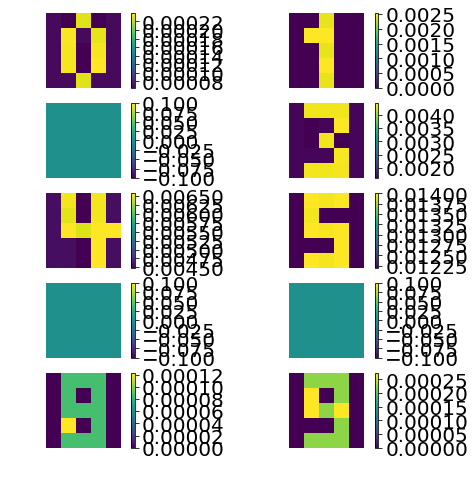

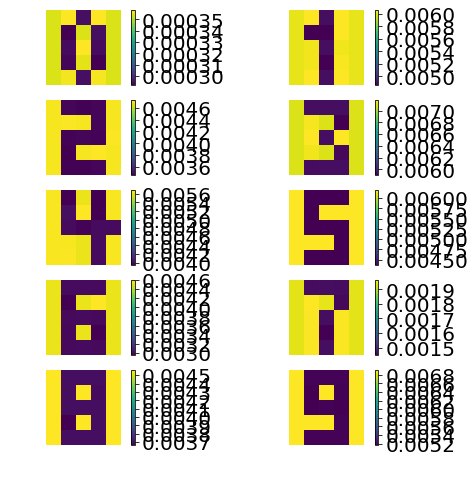

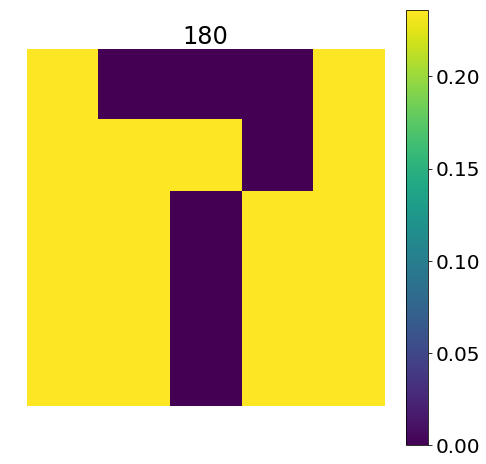

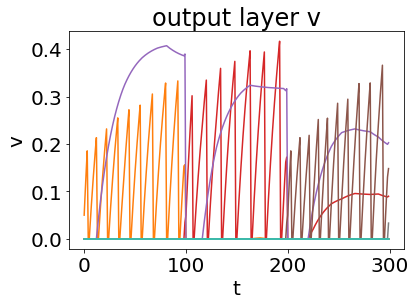

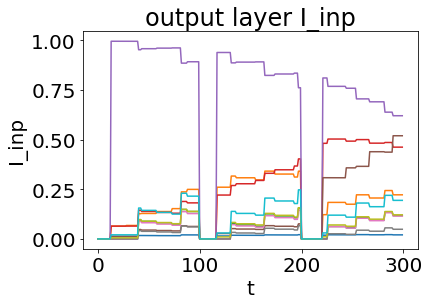

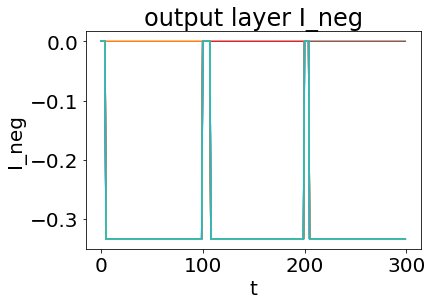

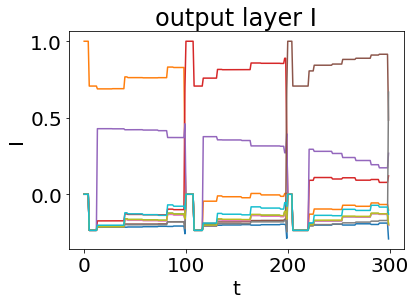

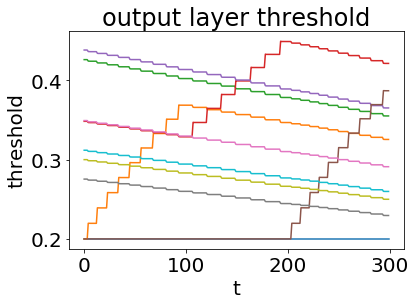

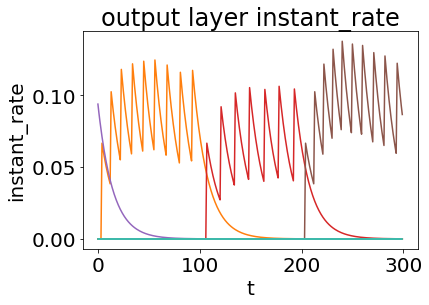

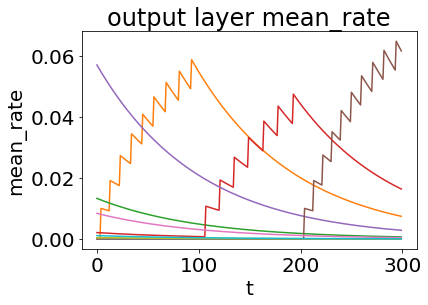

In [44]:
#TRAIN
show_time=20

for i in np.arange(20000):
    #input = torch.from_numpy(get_digit((i // 100) %10))
    input = X[(i // T)] 
    input_normalized_1 = input / input.norm()
    input_normalized_2 = (1-input) / (1-input).norm()
    target = y[(i // T)]
    
    x1 = input_layer(input_normalized_1)
    x2 = input_inverse_layer(input_normalized_2)
    
    BCM_rule.update_weights(x1)
    BCM_inverse_rule.update_weights(x2)
    
    x1 = BCM_rule(x1)
    x2 = BCM_inverse_rule(x2)
    x = x1+x2
    
    x = output_layer(x, target)
    x = inhibition_rule(x)
    
    if i==0:
        #weights
        fig = plt.figure(figsize=(8,8))
        for j in np.arange(BCM_rule.post_layer.neurons):
            plt.subplot(5, 2,j+1)
            plt.imshow(BCM_rule.weight.cpu().numpy()[:,j].reshape(5,5))
            plt.axis('off')
            plt.colorbar()
        display.display(fig, display_id = 'weights')
        
        #weights_inverse
        fig = plt.figure(figsize=(8,8))
        for j in np.arange(BCM_inverse_rule.post_layer.neurons):
            plt.subplot(5, 2,j+1)
            plt.imshow(BCM_inverse_rule.weight.cpu().numpy()[:,j].reshape(5,5))
            plt.axis('off')
            plt.colorbar()
        display.display(fig, display_id = 'weights_inverse')
        
        #input
        fig = plt.figure(figsize=(8,8))
        plt.title(str(i // T))
        plt.imshow(input_normalized_2.cpu().numpy().reshape(5,5))
        plt.axis('off')
        plt.colorbar()
        display.display(fig, display_id = 'input')
        
        #monitors
        for key in output_layer.monitor.monitor_dict.keys():
            fig = plt.figure('output' + key)
            plt.cla()
            plt.title('output layer ' + key)
            x = np.array(output_layer.monitor.monitor_dict[key])
            x = x.reshape(x.shape[0],-1)
            plt.plot(x)
            plt.ylabel(key)
            plt.xlabel('t')
            display.display(fig, display_id = 'output layer ' + key)
    else:
        if i%(show_time*T)==0:
            #weights
            fig = plt.figure(figsize=(8,8))
            for j in np.arange(BCM_rule.post_layer.neurons):
                plt.subplot(5,2,j+1)
                plt.imshow(BCM_rule.weight.cpu().numpy()[:,j].reshape(5,5))
                plt.axis('off')
                plt.colorbar()
            display.update_display(fig, display_id = 'weights')
            
            #weights_inverse
            fig = plt.figure(figsize=(8,8))
            for j in np.arange(BCM_inverse_rule.post_layer.neurons):
                plt.subplot(5, 2,j+1)
                plt.imshow(BCM_inverse_rule.weight.cpu().numpy()[:,j].reshape(5,5))
                plt.axis('off')
                plt.colorbar()
            display.update_display(fig, display_id = 'weights_inverse')
            
            #input
            fig = plt.figure(figsize=(8,8))
            plt.title(str(i // T))
            plt.imshow(input_normalized_2.cpu().numpy().reshape(5,5))
            plt.axis('off')
            plt.colorbar()
            display.update_display(fig, display_id = 'input')
            
            #monitors
            for key in output_layer.monitor.monitor_dict.keys():
                fig = plt.figure('output' + key)
                plt.cla()
                plt.title('output layer ' + key)
                x = np.array(output_layer.monitor.monitor_dict[key])
                x = x.reshape(x.shape[0],-1)
                plt.plot(x)
                plt.ylabel(key)
                plt.xlabel('t')
                display.update_display(fig, display_id = 'output layer ' + key)
                
    if i%T==0:
        input_layer.reset_parameters()
        input_inverse_layer.reset_parameters()
        output_layer.reset_parameters()
        

In [ ]:
#TEST
targets = []
predicts = []
show_time = 20
for i in np.arange(20000):
    input = X[(i // T)] 
    input_normalized_1 = input / input.norm()
    input_normalized_2 = (1-input) / (1-input).norm()
    target = y[(i // T)]
    
    x1 = input_layer(input_normalized_1)
    x2 = input_inverse_layer(input_normalized_2)
    
    #BCM_rule.update_weights(x1)
    #BCM_inverse_rule.update_weights(x2)
    
    x1 = BCM_rule(x1)
    x2 = BCM_inverse_rule(x2)
    x = x1+x2
    
    x = output_layer(x)
    x = inhibition_rule(x)
    
    if i==0:
        #weights
        fig = plt.figure(figsize=(8,8))
        for j in np.arange(BCM_rule.post_layer.neurons):
            plt.subplot(5, 2,j+1)
            plt.imshow(BCM_rule.weight.cpu().numpy()[:,j].reshape(5,5))
            plt.axis('off')
            plt.colorbar()
        display.display(fig, display_id = 'weights')
        
        #weights_inverse
        fig = plt.figure(figsize=(8,8))
        for j in np.arange(BCM_inverse_rule.post_layer.neurons):
            plt.subplot(5, 2,j+1)
            plt.imshow(BCM_inverse_rule.weight.cpu().numpy()[:,j].reshape(5,5))
            plt.axis('off')
            plt.colorbar()
        display.display(fig, display_id = 'weights_inverse')
        
        #input
        fig = plt.figure(figsize=(8,8))
        plt.title(str(i // T))
        plt.imshow(input_normalized_2.cpu().numpy().reshape(5,5))
        plt.axis('off')
        plt.colorbar()
        display.display(fig, display_id = 'input')
        
        #monitors
        for key in output_layer.monitor.monitor_dict.keys():
            fig = plt.figure('output' + key)
            plt.cla()
            plt.title('output layer ' + key)
            x = np.array(output_layer.monitor.monitor_dict[key])
            x = x.reshape(x.shape[0],-1)
            plt.plot(x)
            plt.ylabel(key)
            plt.xlabel('t')
            display.display(fig, display_id = 'output layer ' + key)
    else:
        if i%(show_time*T)==0:
            #weights
            fig = plt.figure(figsize=(8,8))
            for j in np.arange(BCM_rule.post_layer.neurons):
                plt.subplot(5,2,j+1)
                plt.imshow(BCM_rule.weight.cpu().numpy()[:,j].reshape(5,5))
                plt.axis('off')
                plt.colorbar()
            display.update_display(fig, display_id = 'weights')
            
            #weights_inverse
            fig = plt.figure(figsize=(8,8))
            for j in np.arange(BCM_inverse_rule.post_layer.neurons):
                plt.subplot(5, 2,j+1)
                plt.imshow(BCM_inverse_rule.weight.cpu().numpy()[:,j].reshape(5,5))
                plt.axis('off')
                plt.colorbar()
            display.update_display(fig, display_id = 'weights_inverse')
            
            #input
            fig = plt.figure(figsize=(8,8))
            plt.title(str(i // T))
            plt.imshow(input_normalized_2.cpu().numpy().reshape(5,5))
            plt.axis('off')
            plt.colorbar()
            display.update_display(fig, display_id = 'input')
            
            #monitors
            for key in output_layer.monitor.monitor_dict.keys():
                fig = plt.figure('output' + key)
                plt.cla()
                plt.title('output layer ' + key)
                x = np.array(output_layer.monitor.monitor_dict[key])
                x = x.reshape(x.shape[0],-1)
                plt.plot(x)
                plt.ylabel(key)
                plt.xlabel('t')
                display.update_display(fig, display_id = 'output layer ' + key)
            print(accuracy_score(np.array(targets), np.array(predicts)))
        
    if i%T==0:
        input_layer.reset_parameters()
        input_inverse_layer.reset_parameters()
        output_layer.reset_parameters()
        
        

In [ ]:
len(targets)

In [ ]:
len(predicts)

In [ ]:
accuracy_score(np.array(targets), np.array(predicts))

In [ ]:
fig = plt.figure(figsize=(8,8))
for j in np.arange(BCM_rule.post_layer.neurons):
    plt.subplot(5,2,j+1)
    plt.imshow(BCM_rule.weight.cpu().numpy()[:,j].reshape(5,5))
    plt.axis('off')
    plt.colorbar()
plt.show()